# MLOps 2025

Project: https://www.kaggle.com/code/drvaibhavkumar/lstm-for-time-series-prediction-in-pytorch


Data: https://ru.investing.com/equities/yandex-historical-data?ysclid=m81ihsakju683720297

In [65]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from permetrics.regression import RegressionMetric
from sklearn.metrics import r2_score

In [67]:
data = pd.read_csv('YDEX.csv')
data.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,07.03.2025,"4.553,0","4.510,0","4.640,0","4.474,0","1,32M","0,88%"
1,06.03.2025,"4.513,5","4.498,0","4.577,5","4.480,0","561,49K","0,37%"
2,05.03.2025,"4.497,0","4.586,0","4.630,0","4.470,0","925,38K","-1,94%"
3,04.03.2025,"4.586,0","4.368,0","4.619,5","4.356,0","1,43M","5,49%"
4,03.03.2025,"4.347,5","4.450,0","4.455,0","4.260,0","1,16M","-1,71%"


In [69]:
data = data['Цена']
data.head()

0    4.553,0
1    4.513,5
2    4.497,0
3    4.586,0
4    4.347,5
Name: Цена, dtype: object

In [71]:
def data_preproc(x):
    return x[:-2]

In [73]:
data = data.apply(data_preproc)
data.head()

0    4.553
1    4.513
2    4.497
3    4.586
4    4.347
Name: Цена, dtype: object

In [75]:
data.shape

(484,)

In [77]:
all_data = data.astype(float)
all_data = all_data * 1000
all_data.head()

0    4553.0
1    4513.0
2    4497.0
3    4586.0
4    4347.0
Name: Цена, dtype: float64

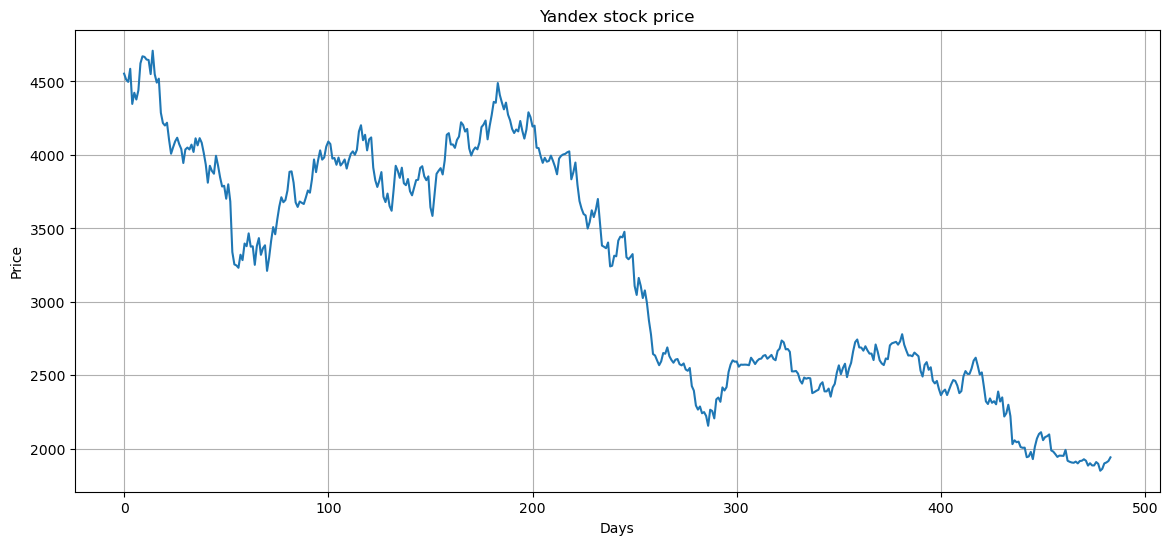

In [79]:
plt.figure(figsize=(14, 6))
plt.grid(True)
plt.title('Yandex stock price')
plt.ylabel('Price')
plt.xlabel('Days')
display(plt.plot(list(range(len(all_data))), list(all_data)))

In [81]:
test_data_size = 10

train_data = np.array(all_data[:-test_data_size])
test_data = np.array(all_data[-test_data_size:])

In [83]:
print(len(train_data))
print(len(test_data))

474
10


In [85]:
print(test_data)

[1887. 1887. 1910. 1898. 1851. 1864. 1901. 1907. 1917. 1942.]


In [87]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [89]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[0.88947928]
 [0.86114063]
 [0.84980517]
 [0.91285866]
 [0.74353525]]
[[-0.97662062]
 [-0.96953595]
 [-0.97662062]
 [-1.        ]
 [-0.98866454]]


In [91]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [93]:
train_window = 10

In [95]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [97]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [99]:
train_inout_seq[:5]

[(tensor([0.8895, 0.8611, 0.8498, 0.9129, 0.7435, 0.7974, 0.7648, 0.8094, 0.9391,
          0.9731]),
  tensor([0.9702])),
 (tensor([0.8611, 0.8498, 0.9129, 0.7435, 0.7974, 0.7648, 0.8094, 0.9391, 0.9731,
          0.9702]),
  tensor([0.9575])),
 (tensor([0.8498, 0.9129, 0.7435, 0.7974, 0.7648, 0.8094, 0.9391, 0.9731, 0.9702,
          0.9575]),
  tensor([0.9554])),
 (tensor([0.9129, 0.7435, 0.7974, 0.7648, 0.8094, 0.9391, 0.9731, 0.9702, 0.9575,
          0.9554]),
  tensor([0.8874])),
 (tensor([0.7435, 0.7974, 0.7648, 0.8094, 0.9391, 0.9731, 0.9702, 0.9575, 0.9554,
          0.8874]),
  tensor([1.]))]

In [249]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Инициализация LSTM с несколькими слоями
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)

        # Линейный слой для преобразования выхода LSTM в выходной размер
        self.linear = nn.Linear(hidden_layer_size, output_size)

        # Инициализация скрытого состояния и состояния ячейки
        self.hidden_cell = (torch.zeros(num_layers, 1, self.hidden_layer_size),
                            torch.zeros(num_layers, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        # Преобразование входной последовательности для LSTM
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        
        # Преобразование выхода LSTM через линейный слой
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        
        # Возвращаем последний элемент последовательности
        return predictions[-1]

In [275]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [277]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [279]:
epochs = 10
num_layers = 1

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(num_layers, 1, model.hidden_layer_size),
                        torch.zeros(num_layers, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00198626
epoch:   9 loss: 0.0009551453


In [281]:
fut_pred = 10

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.9851222038269043, -0.9865391254425049, -0.9808714389801025, -0.9893730282783508, -0.9780375361442566, -0.976620614528656, -0.9695359468460083, -0.976620614528656, -1.0, -0.9886645674705505]


In [283]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [285]:
test_inputs[fut_pred:]

[-1.011487603187561,
 -1.0251076221466064,
 -1.03426194190979,
 -1.0398330688476562,
 -1.042788028717041,
 -1.0440678596496582,
 -1.0444259643554688,
 -1.044381856918335,
 -1.0442270040512085,
 -1.0440905094146729]

In [287]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[1869.7852481 ]
 [1850.56059134]
 [1837.63926899]
 [1829.77562332]
 [1825.60469747]
 [1823.7982161 ]
 [1823.29275131]
 [1823.35500896]
 [1823.57358378]
 [1823.76624596]]


In [289]:
x = np.arange(474, 484, 1)
print(x)

[474 475 476 477 478 479 480 481 482 483]


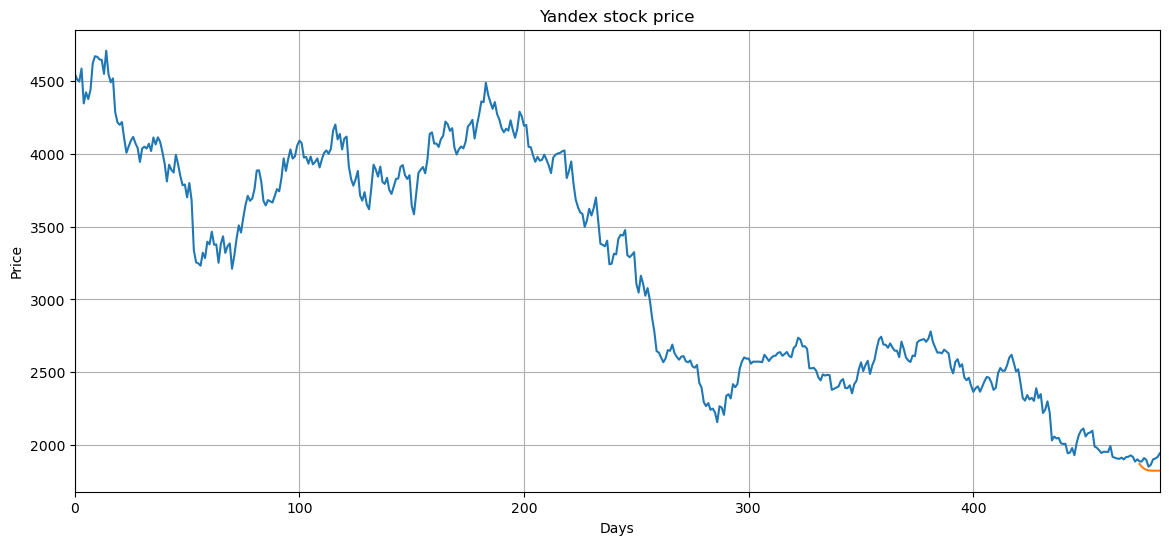

In [291]:
plt.figure(figsize=(14, 6))
plt.title('Yandex stock price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot((range(len(all_data))), list(all_data))
plt.plot(x,actual_predictions)
plt.show()

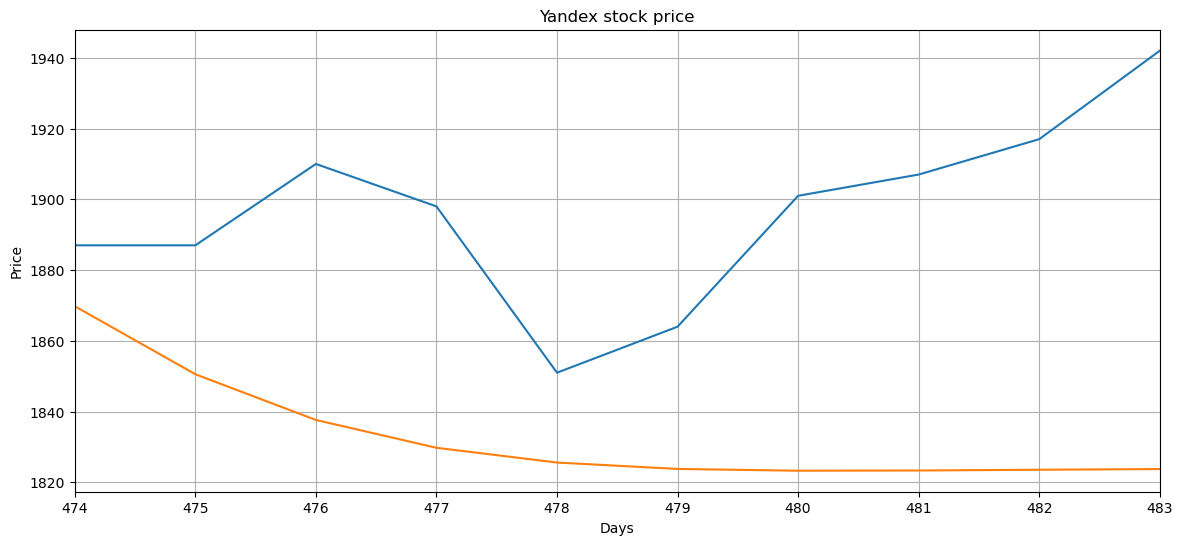

In [293]:
plt.figure(figsize=(14, 6))
plt.title('Yandex stock price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(all_data[-train_window:])
plt.plot(x,actual_predictions)
plt.show()

In [295]:
y_pred = np.reshape(actual_predictions, (1, 10))[0]
y_true = np.array(all_data[-10:])

In [297]:
evaluator = RegressionMetric(y_true, y_pred)
print(evaluator.mean_absolute_scaled_error())

3.2922768103594153
